In [4]:
import pandas as pd
import os
from datetime import datetime, timedelta
from tqdm import tqdm
import gc
import sys

import matplotlib.pyplot as plt

import MetaTrader5 as mt5
import talib

path_root = "D:/Documentos/Erik/TDR/TDR-Forex/"
sys.path.append(path_root)
from utils.mt5 import init_mt5
from utils.data import get_symbols_info, save_data

output_path = os.path.join(path_root, "output", "Forex")
os.makedirs(output_path, exist_ok=True)

### Obtenint símbols de forex disponibles a MT5

In [5]:
symbols = get_symbols_info(path_root, save=True)
symbols.head(2)

We have 123 forex symbols


,name,description,currency_base,currency_quote,digits,spread,point,volume_min,volume_max,swap_long,swap_short
0,AUDCAD,Australian Dollar vs Canadian Dollar,AUD,CAD,5,0,0.00001,0.01,500.0,6.4,-15.4
1,AUDCHF,Australian Dollar vs Swiss Franc,AUD,CHF,5,0,0.00001,0.01,500.0,7.1,-15.8


### Guardant històric de les majors

Guardant dades:   0%|                                                                        | 0/1 [00:00<?, ?símbol/s]

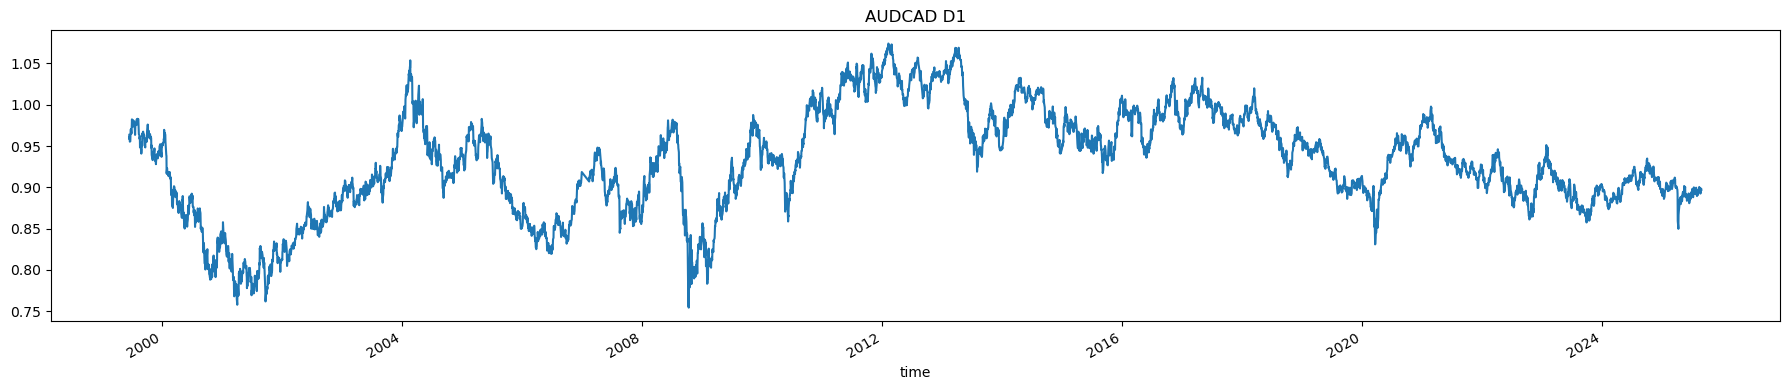

,símbol,finestra,inici,fi,MB,n_barres
0,AUDCAD,M1,1999-06-15,2025-08-26 10:55:00,72.53,6831728
1,AUDCAD,M5,1999-06-15,2025-08-26 11:00:00,17.03,1379439
2,AUDCAD,M15,1999-06-15,2025-08-26 11:00:00,6.22,461454
3,AUDCAD,H1,1999-06-15,2025-08-26 11:00:00,1.73,116925
4,AUDCAD,D1,1999-06-15,2025-08-26 00:00:00,0.11,6790


Guardant dades: 100%|███████████████████████████████████████████████████████████████| 1/1 [06:08<00:00, 368.51s/símbol]


In [6]:
start = datetime(2000,1,1) - timedelta(days=200)
end = datetime(2030,1,1)
symbols = ["EURUSD", "GBPUSD", "USDJPY", "USDCHF", "NZDUSD", "USDCAD", "AUDUSD"]
symbols = ["AUDCAD"]
save_data(symbols, start, end, path_root)

### Qualitat de les dades D1

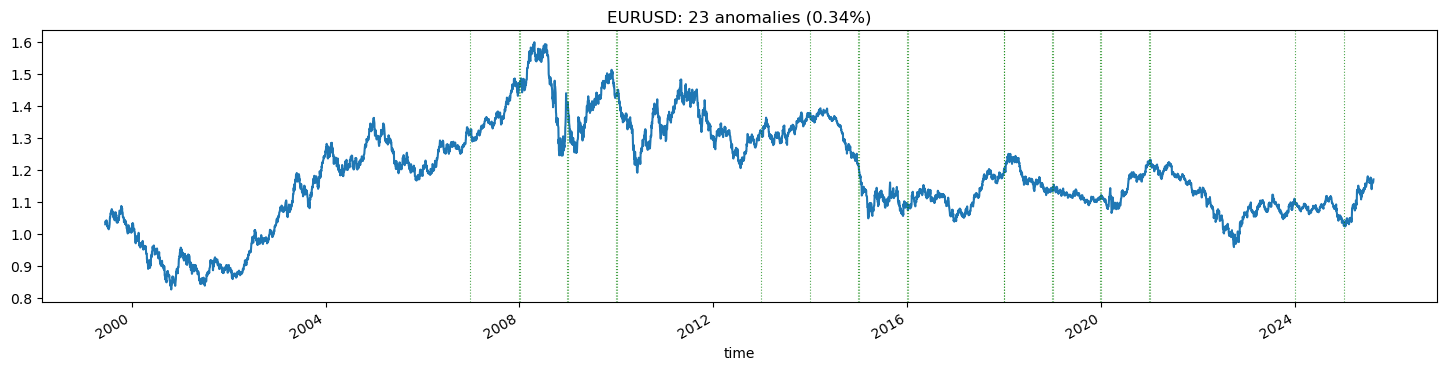

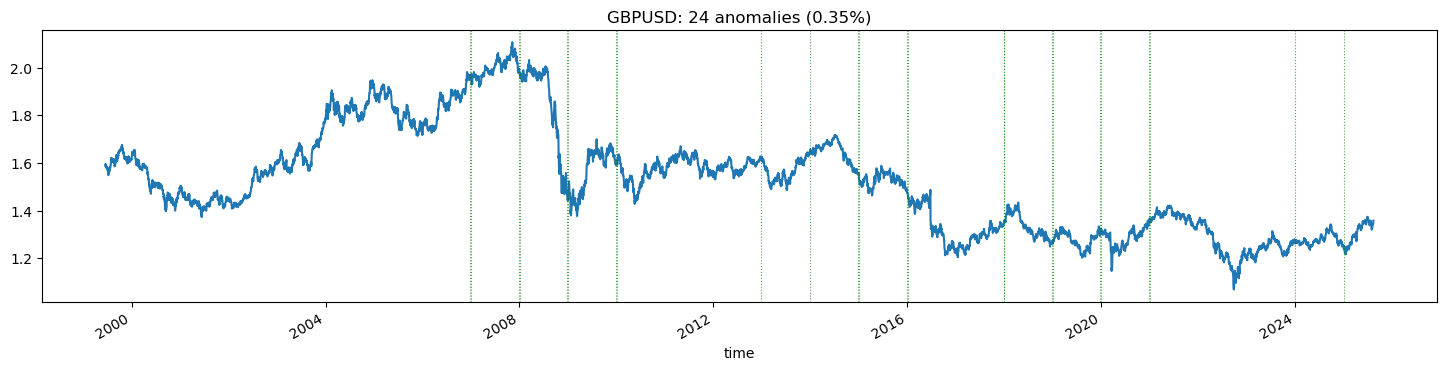

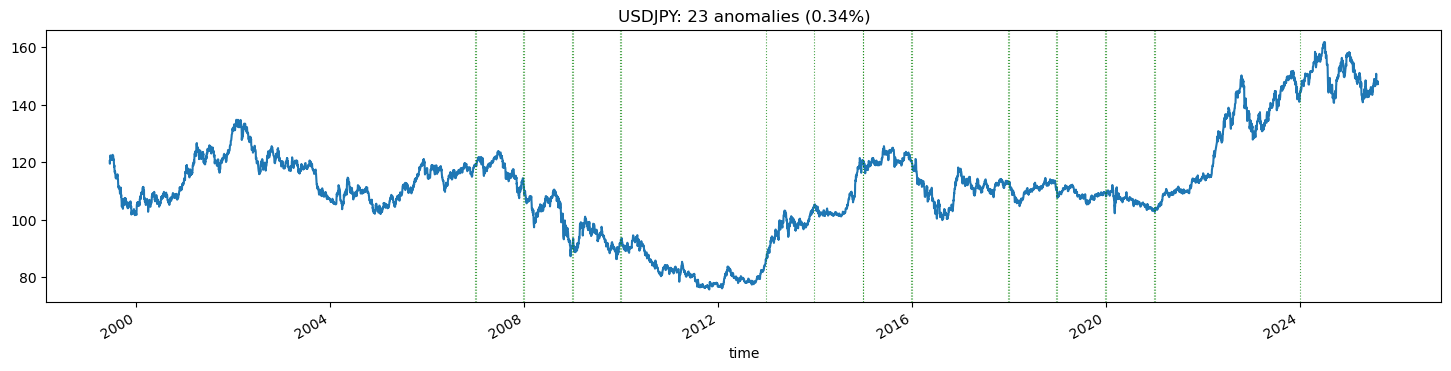

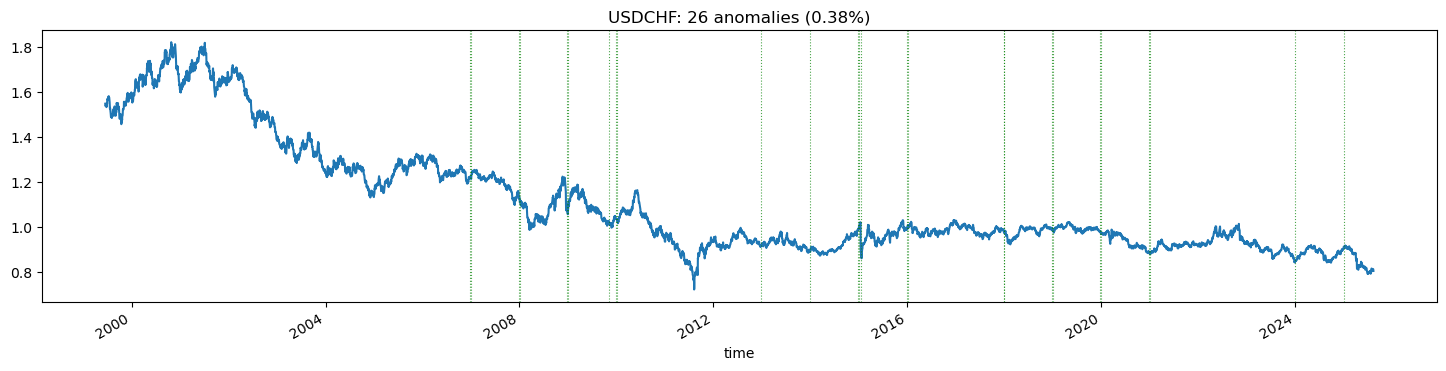

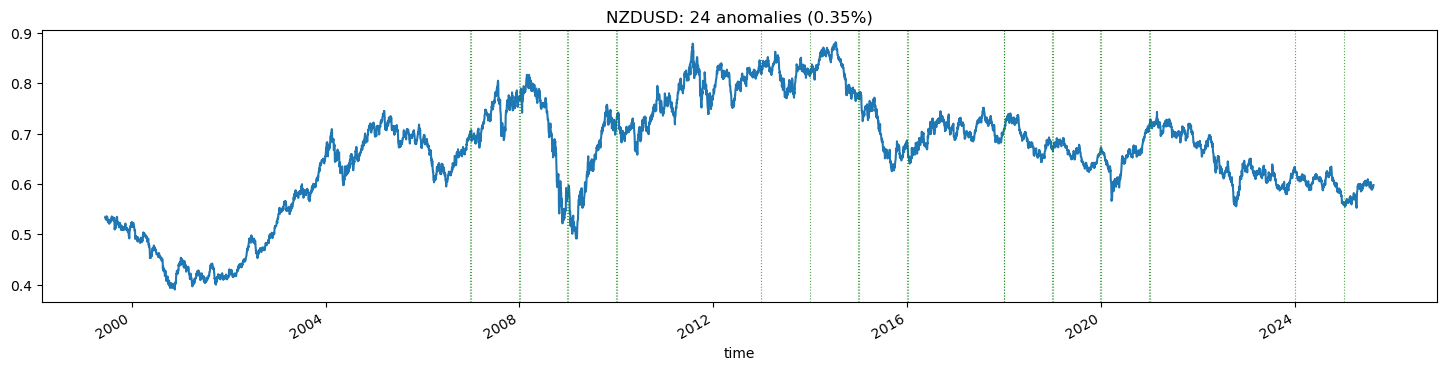

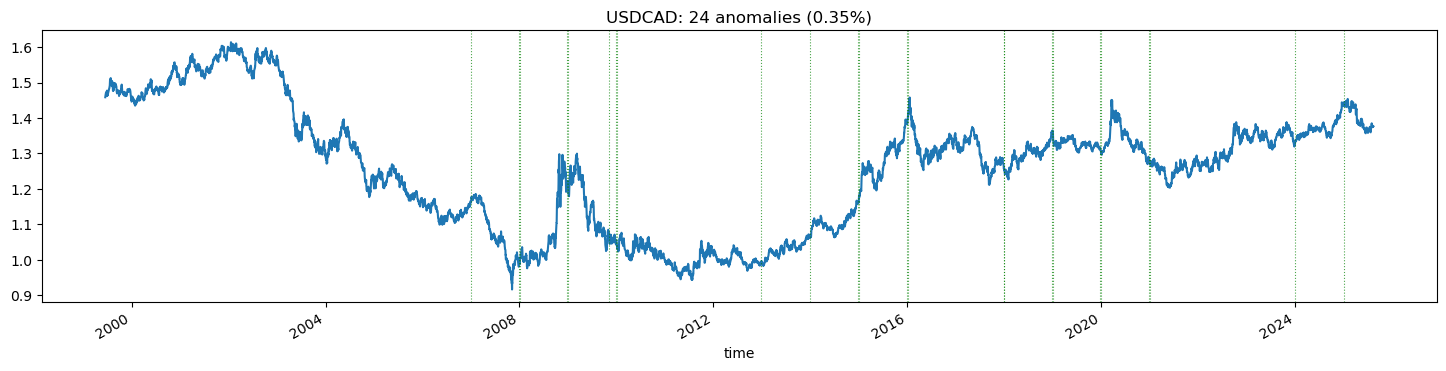

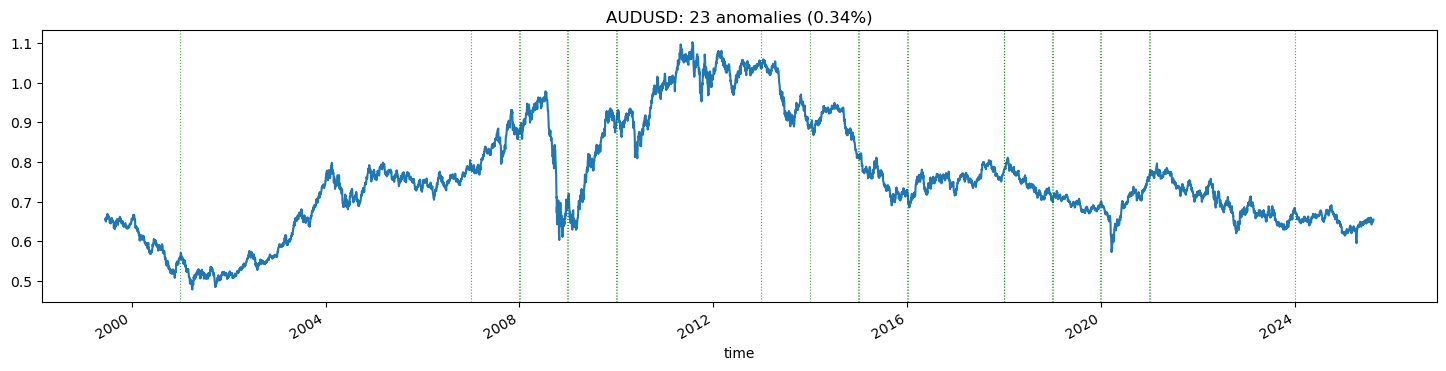

In [4]:
timeframe = "D1"
for symbol in symbols:
    path_data = os.path.join(path_root, "output", "Forex", timeframe)
    filename = os.path.join(path_data, f"{symbol}.csv.gz")
    data = pd.read_csv(filename, parse_dates=["time"])
    data["dow"] = data.time.dt.dayofweek
    data["diff_time"] = data.time.diff().dt.days
    data = data.dropna().reset_index(drop=True)
    anomalies = data[((data['diff_time'] > 1) & (data.dow != 0)) | (data.diff_time != 3) & (data.dow==0)].reset_index(drop=True)
    dates_anomalies = anomalies.time.tolist()
    perc_anomalies = len(dates_anomalies)/len(data)*100
    plt.figure(figsize=(18,4))
    data.set_index('time').close.plot(title=f"{symbol}: {len(dates_anomalies)} anomalies ({perc_anomalies:.2f}%)")
    for x in dates_anomalies:
        plt.axvline(x, color='green', linestyle=':', linewidth=0.8, alpha=0.7)
    plot_path = os.path.join(path_root, "output", "Forex", "charts")
    os.makedirs(plot_path, exist_ok=True)
    plt.savefig(os.path.join(plot_path, f"{symbol}_anomalies_{timeframe}.png"), dpi=150, bbox_inches='tight')    
    plt.show()

### Qualitat dades H1

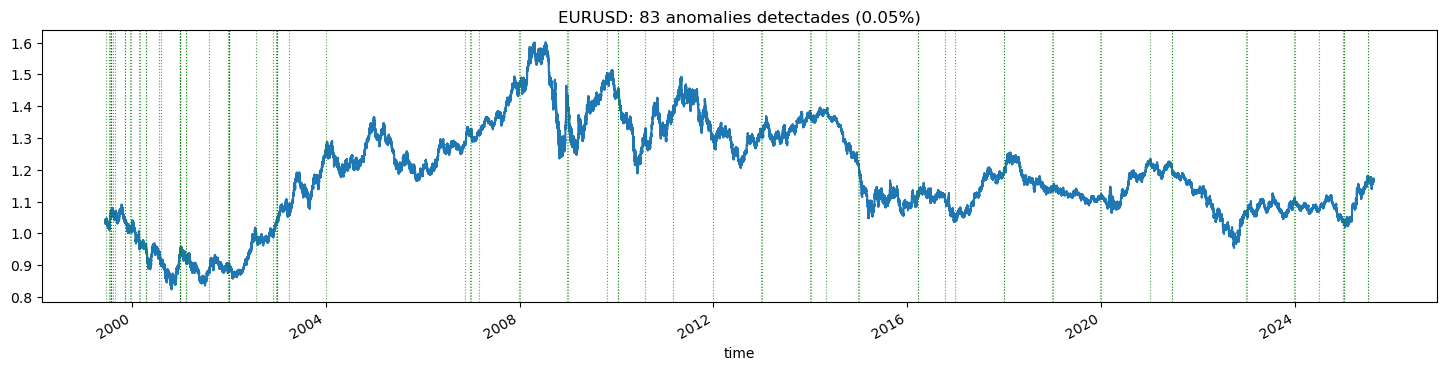

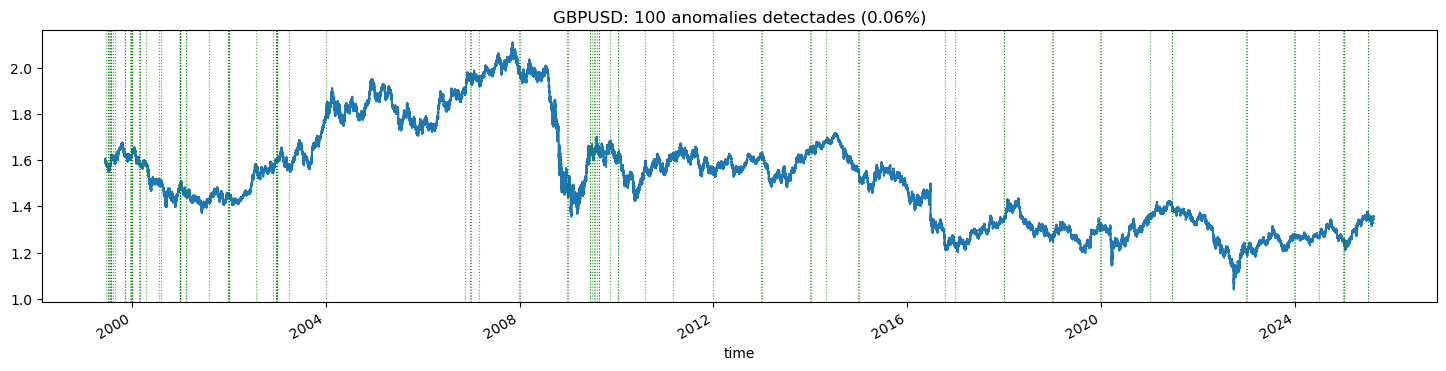

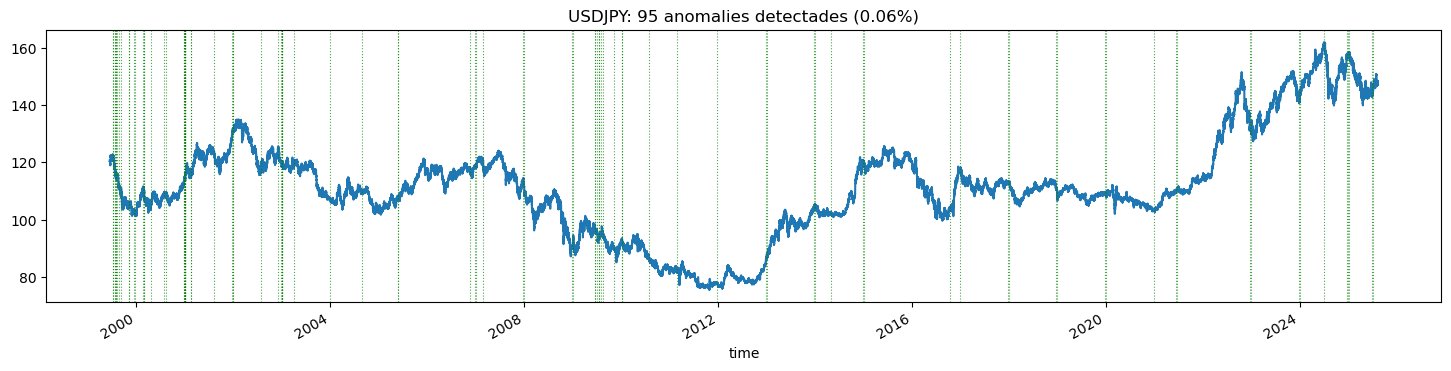

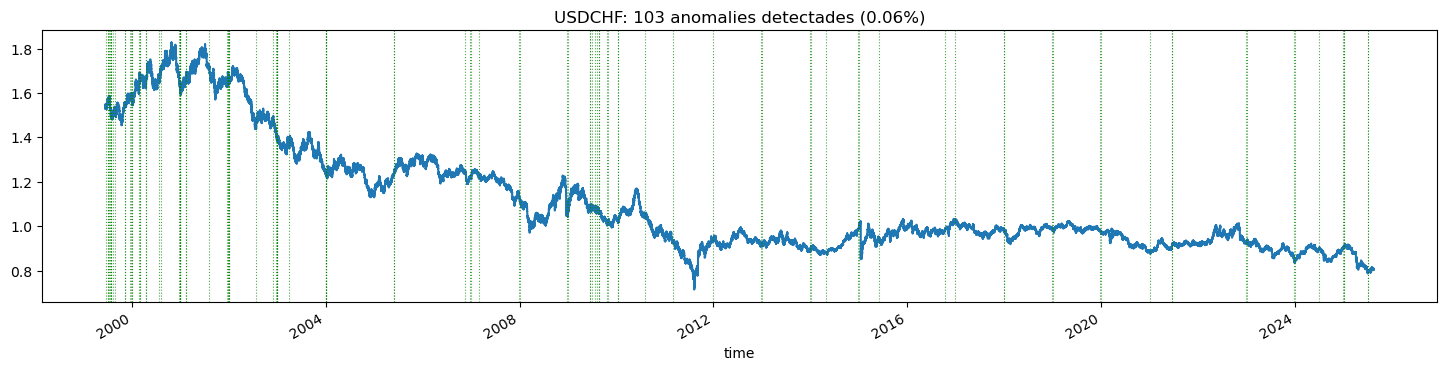

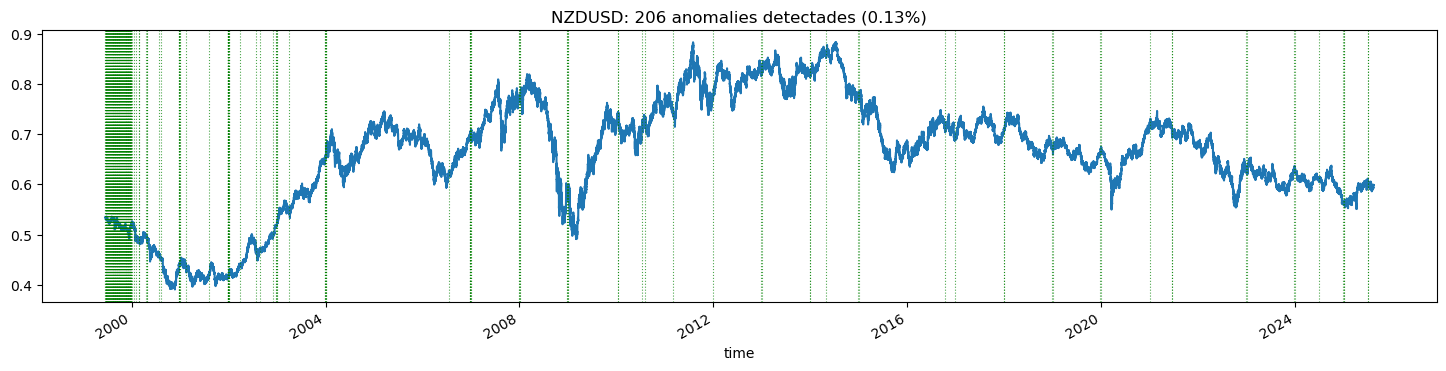

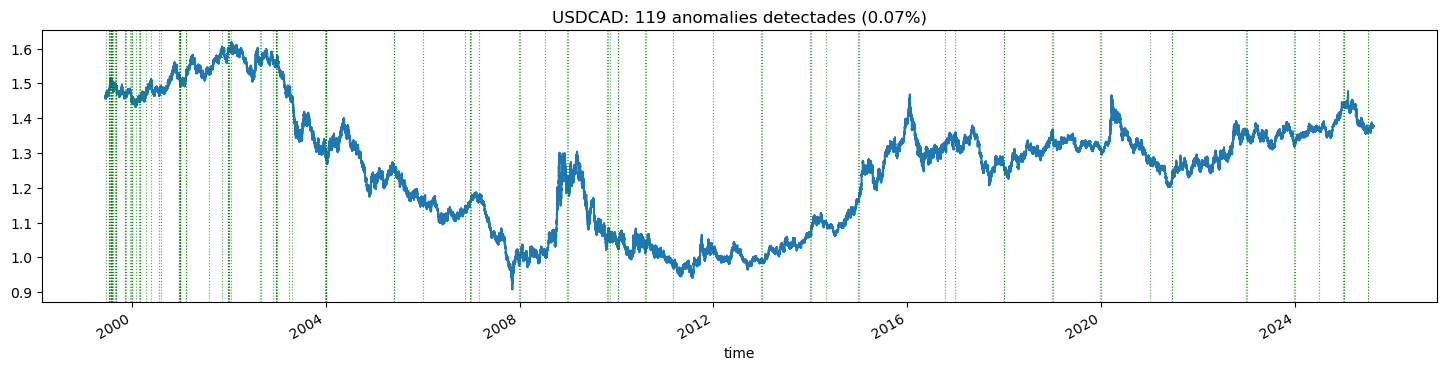

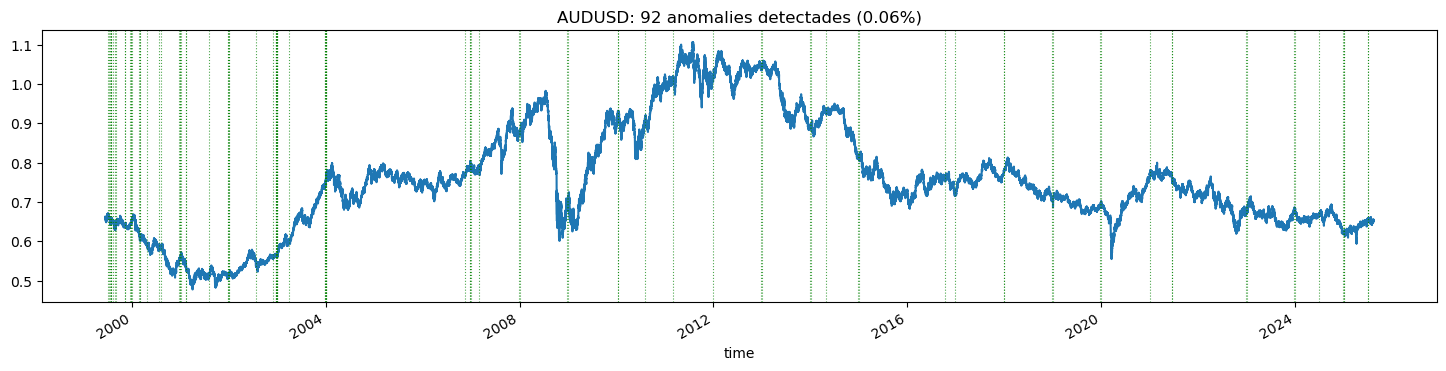

In [5]:
timeframe = "H1"; 
for symbol in symbols:
    path_data = os.path.join(path_root, "output", "Forex", timeframe)
    filename = os.path.join(path_data, f"{symbol}.csv.gz")
    data = pd.read_csv(filename, parse_dates=["time"])
    data["dow"] = data.time.dt.dayofweek
    data["year"] = data.time.dt.year
    data["month"] = data.time.dt.month
    data["day"] = data.time.dt.day
    data["hour"] = data.time.dt.hour
    data["diff_time"] = data.time.diff().dt.total_seconds() / 3600
    data = data.dropna()
    anomalies = ~((data['diff_time'] == 1) | ((data['dow'] == 0) & (data['hour'] == 0)))
    titol = f"{symbol}: {sum(anomalies)} anomalies detectades ({sum(anomalies)/len(data)*100:.2f}%)"
    plt.figure(figsize=(18,4))
    data.set_index('time').close.plot(title=titol)
    for x in data[anomalies].time.unique():
        plt.axvline(x, color='green', linestyle=':', linewidth=0.8, alpha=0.7)
    plot_path = os.path.join(path_root, "output", "Forex", "charts")
    os.makedirs(plot_path, exist_ok=True)  # Crea carpeta si no existeix
    plt.savefig(os.path.join(plot_path, f"{symbol}_anomalies_{timeframe}.png"), dpi=150, bbox_inches='tight')            
    plt.show()

### Qualitat dades M1

EURUSD: 4946 anomalies detectades (0.05%)


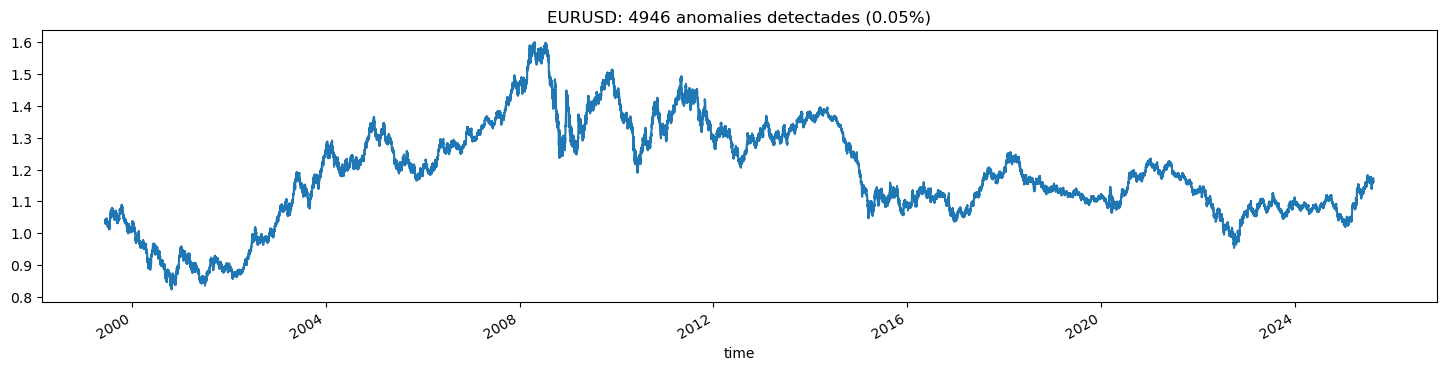

GBPUSD: 10019 anomalies detectades (0.11%)


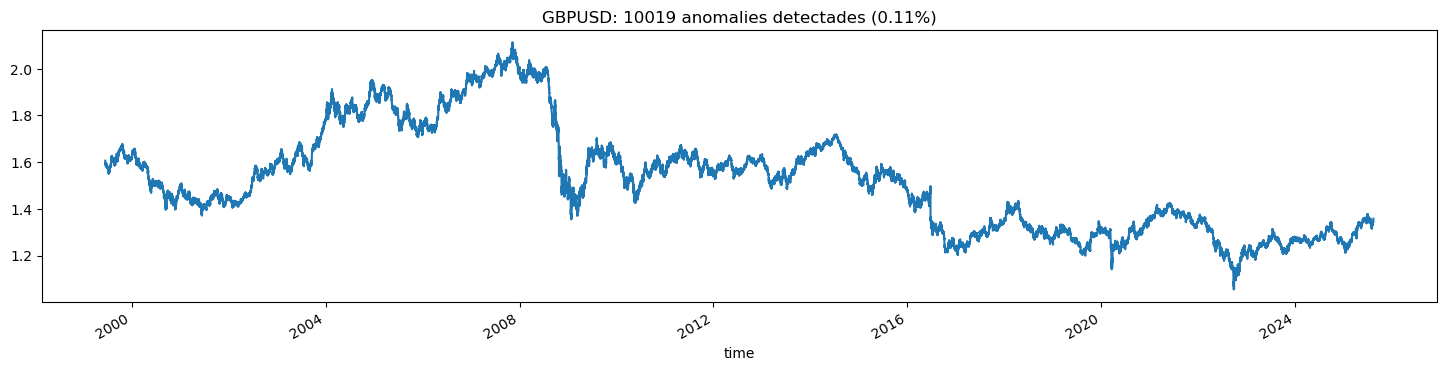

USDJPY: 4952 anomalies detectades (0.05%)


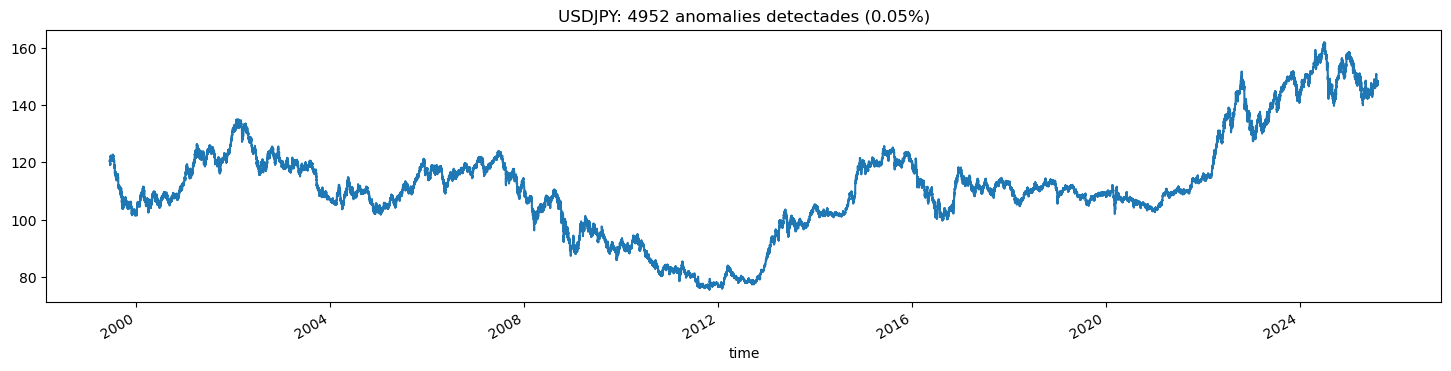

USDCHF: 8473 anomalies detectades (0.09%)


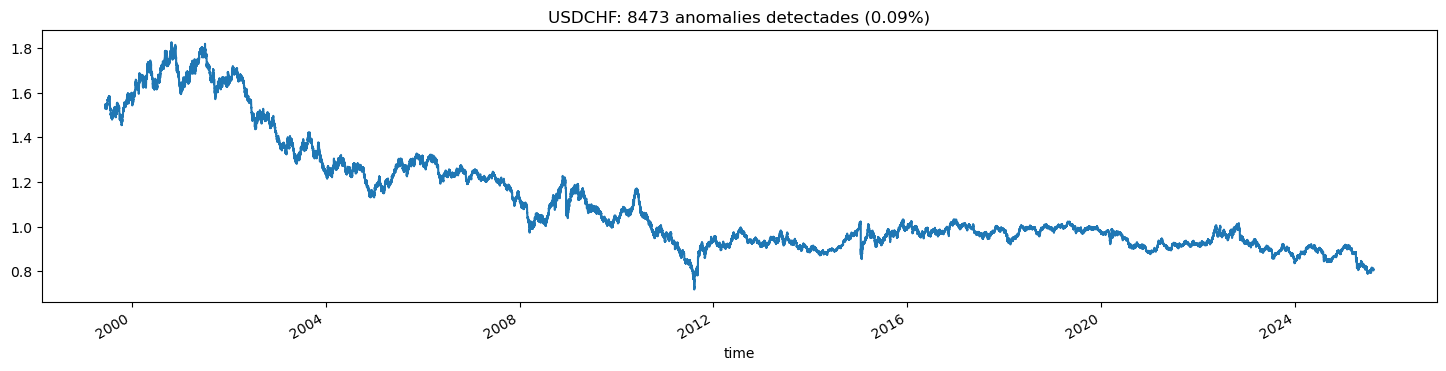

NZDUSD: 35092 anomalies detectades (0.41%)


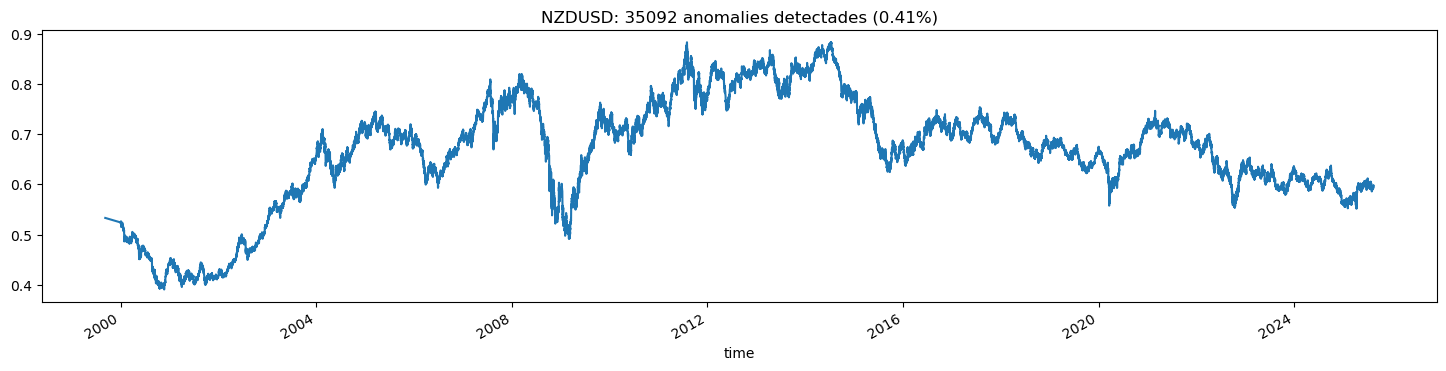

USDCAD: 31788 anomalies detectades (0.35%)


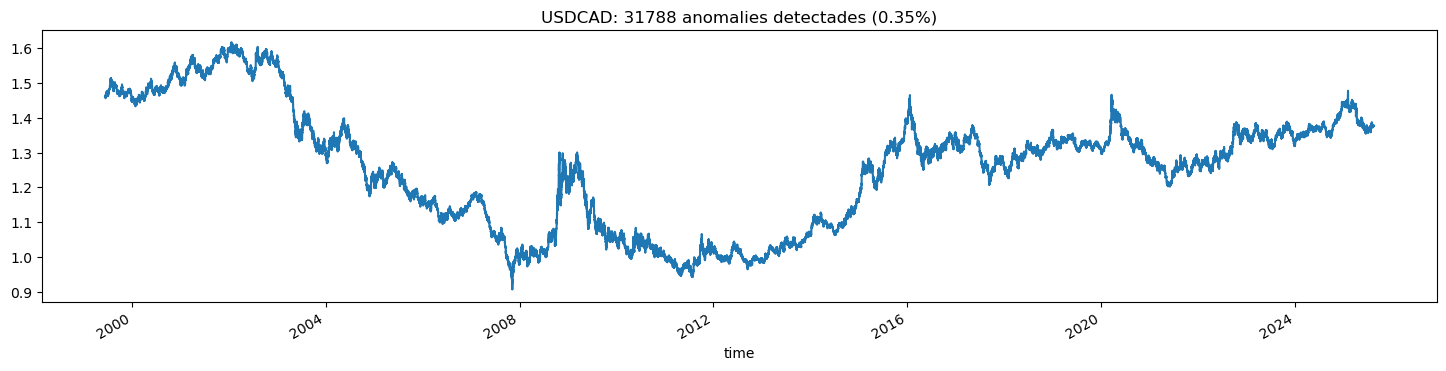

AUDUSD: 17231 anomalies detectades (0.19%)


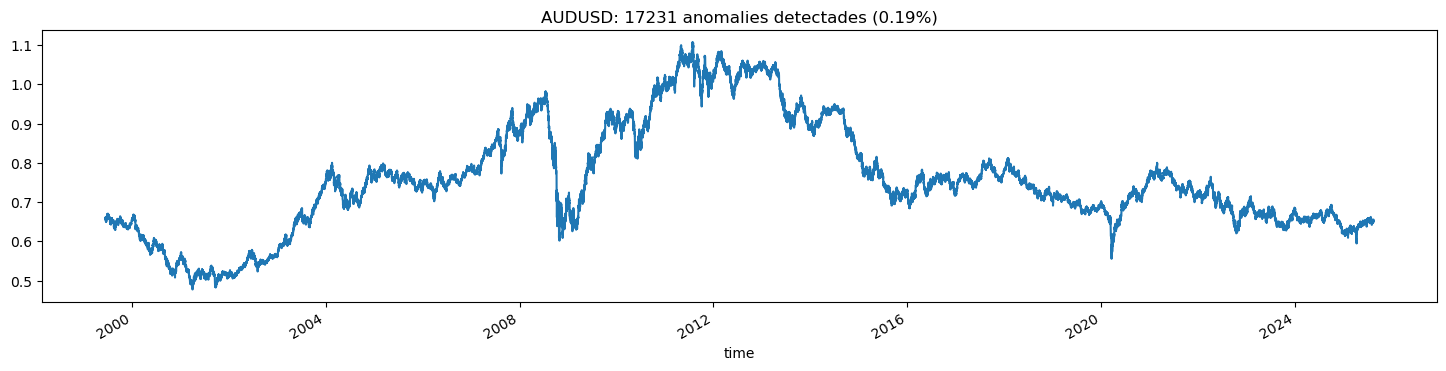

In [6]:
timeframe = "M1"; 
for symbol in symbols:
    path_data = os.path.join(path_root, "output", "Forex", timeframe)
    filename = os.path.join(path_data, f"{symbol}.csv.gz")
    data = pd.read_csv(filename, parse_dates=["time"])
    data["dow"] = data.time.dt.dayofweek
    data["year"] = data.time.dt.year
    data["month"] = data.time.dt.month
    data["day"] = data.time.dt.day
    data["hour"] = data.time.dt.hour
    data["diff_time"] = data.time.diff().dt.total_seconds() / 60
    data = data.dropna()
    anomalies = ~((data['diff_time'] <= 5) | ((data['dow'] == 0) & (data['hour'] == 0)))
    titol = f"{symbol}: {sum(anomalies)} anomalies detectades ({sum(anomalies)/len(data)*100:.2f}%)"
    print(titol)
    plt.figure(figsize=(18,4))
    data.sample(frac=0.01, random_state=42).sort_values(by="time").set_index('time').close.plot(title=titol)
    plot_path = os.path.join(path_root, "output", "Forex", "charts")
    os.makedirs(plot_path, exist_ok=True)  # Crea carpeta si no existeix
    plt.savefig(os.path.join(plot_path, f"{symbol}_anomalies_{timeframe}.png"), dpi=150, bbox_inches='tight')        
    plt.show()